## <p style="font-family:newtimeroman;font-size:150%;text-align:center;">Brain Tumor Detection using<br>EfficientNetB0, ResNet101, and Xception</p>

# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Introduction</p>

In my previous exploration of the Brain Tumor dataset ([Brain Tumor Detection using Tensorflow CNN](https://www.kaggle.com/code/anitarostami/brain-tumor-detection-using-tensorflow-cnn#notebook-container)), I delved into Image Classification using CNNs and compared augmented and unaugmented models. While both approaches provided insights, the unaugmented model shown potential for balancing accuracy and computational efficiency . However, due to the dataset's size limits, reaching ideal accuracy remained difficult. In this new notebook, I switch to Transfer Learning and use pre-trained models like EfficientNetB0, ResNet101, and Xception to significantly enhance classification accuracy.

<div class="alert alert-block alert-info"> <b>NOTE</b> I hope you found value and insights in this notebook. If you have any suggestions or thoughts, please feel free to share them. If you enjoyed the content, consider giving it an upvote. Thank you! </div>

   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. DATA PREPRATION](#2)
    
* [2. TRANSFER LEARNING](#3)
    
* [3. EfficientNetB0](#4)
    
* [4. ResNet101](#5)   
      
* [6. Xception](#6)
    
* [7. CONCLUSION](#7)

<a id="1"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Importing Libraries</p>

In [1]:
!pip install mplcyberpunk

In [3]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp /content/kaggle_key.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!cat ~/.kaggle/kaggle.json


{"username":"navaneethvn","key":"fc81733469d977f3db9e9d5e400b280f"}

In [5]:
!kaggle datasets list | head -5


ref                                                             title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                             Chocolate Sales                                       468320  2026-01-04 14:23:35.490000          18713        332  1.0              
ashrafkhetran/the-movies-database-tmdb-1950-2025                The Movies database (TMDB) 1950-2025                    4897  2026-02-09 05:35:40.533000           1080         26  1.0              
aliiihussain/amazon-sales-dataset                               Amazon_Sales_Dataset                                 1297759  2026-02-01 11:37:12.353000           4332         79  1.0              


In [6]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri


Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
  0% 0.00/86.8M [00:00<?, ?B/s]
100% 86.8M/86.8M [00:00<00:00, 1.77GB/s]


In [7]:
!ls /content


brain-tumor-classification-mri.zip  kaggle_key.json  sample_data


In [8]:
!unzip -q brain-tumor-classification-mri.zip -d /content


In [9]:
!ls /content


brain-tumor-classification-mri.zip  sample_data  Training
kaggle_key.json			    Testing


In [10]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm

from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/brain-tumor-classification-mri.zip
/content/kaggle_key.json
/content/.config/default_configs.db
/content/.config/config_sentinel
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/.last_survey_prompt.yaml
/content/.config/gce
/content/.config/.last_opt_in_prompt.yaml
/content/.config/active_config
/content/.config/.last_update_check.json
/content/.config/logs/2026.02.06/14.31.35.535753.log
/content/.config/logs/2026.02.06/14.31.44.938153.log
/content/.config/logs/2026.02.06/14.30.32.592228.log
/content/.config/logs/2026.02.06/14.31.28.771044.log
/content/.config/logs/2026.02.06/14.31.45.734270.log
/content/.config/logs/2026.02.06/14.31.19.332851.log
/content/.config/configurations/config_default
/content/Training/pituitary_tumor/p (772).jpg
/content/Training/pituitary_tumor/p (573).jpg
/content/Training/pituitary_tumor/p (652).jpg
/content/Training/pituitary_tumor/p (489).jpg
/content/Training/pituitary_tumor/p (779).jpg
/content/T

<a id="2"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Data Preperation</p>

In [11]:
X_train = []
y_train = []
X_test = []
y_test = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150

for label in labels:
    folderPath = os.path.join('/content/Training', label)
    for file in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, file)
        img = cv2.imread(img_path)

        if img is not None:  # Avoid corrupted images
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(label)


for label in labels:
    folderPath = os.path.join('/content/Testing', label)
    for file in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, file)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            X_test.append(img)
            y_test.append(label)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 74/74 [00:00<00:00, 384.86it/s]


## Data visualization

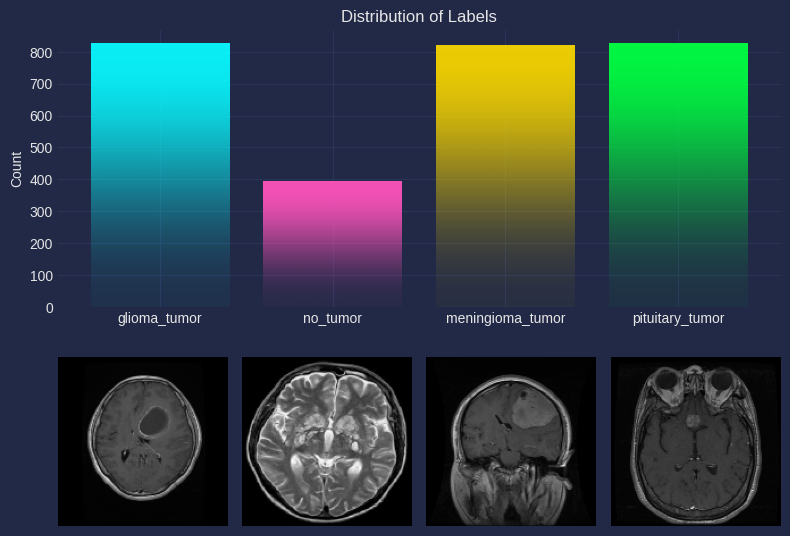

In [12]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()


### Dataset Split: Train and Test

In [13]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One-Hot Encoding Labels

In [15]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

<a id="3"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Transfer Learning</p>

Transfer learning uses knowledge learned from training on one task to improve learning on another, which is especially beneficial when data is limited. The model can learn more quickly and avoid overfitting by using learned features from a related task. It works by starting with a pre-trained model's base layers, identifying transfer layers capturing relevant information, and fine-tuning these layers with new task data to adapt the model efficiently. This method is particularly useful in deep learning for tasks involving image recognition and classification.

**Fundamental Components and Techniques in Neural Network Training**

1. Dense: A fully connected layer that learns complicated patterns in data by connecting all neurons in the previous and subsequent layers.

2. GlobalAveragePooling2D: A pooling layer that determines the average value of each feature map across spatial dimensions, lowering spatial dimensions and keeping crucial information.

3. Dropout: a regularization technique that randomly sets a fraction of input units to zero during training, preventing overfitting and requiring the model to learn resilient features.

4. BatchNormalization: This technique normalizes each layer's activations to stabilize training and reduce internal covariate shift, resulting in faster convergence and improved generalization.

5. Callbacks: Callbacks are TensorFlow/Keras functions that can do specific actions during training, such as storing the model, adjusting learning rates, or halting training based on conditions.

6. Early Stopping: A callback technique that halts training when a monitored metric stops improving, preventing overfitting and conserving computational resources.

<a id="4"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">EfficientNet</p>

* EfficientNet-b0, trained on the huge ImageNet dataset, has learned how to classify images in 1000 different object categories, ranging from ordinary items like keyboards and pencils to numerous animals. Furthermore, EfficientNet models are notable for their efficient architecture, which achieves high accuracy with less parameters than traditional models such as ResNet-101.

* EfficientNet uses a compound scaling approach to consistently scale depth, width, and resolution. Its stem, the first processing layer, consists of a 3x3 Conv2D with stride 2, Batch Normalization, and Swish activation. The Conv2D layer is essential, detecting features and forming complex patterns crucial for CNNs in image recognition tasks. Filters of size 3x3 traverse the input, capturing spatial hierarchies such as edges and textures, while a stride of 2 downsamples, reducing computational load and aiding feature extraction in subsequent layers. This layer's role in the feature hierarchy comprises low-level feature extraction, which contributes to the recognition of complicated features deeper in the network.

In [16]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [18]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [19]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 12, verbose = 1,
                    batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.7506 - loss: 0.6248
Epoch 1: val_accuracy improved from -inf to 0.81081, saving model to efficientnetB0.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 147s 928ms/step - accuracy: 0.7519 - loss: 0.6220 - val_accuracy: 0.8108 - val_loss: 0.8750 - learning_rate: 0.0010
Epoch 2/12
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9352 - loss: 0.2078
Epoch 2: val_accuracy improved from 0.81081 to 0.85328, saving model to efficientnetB0.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 82ms/step - accuracy: 0.9352 - loss: 0.2075 - val_accuracy: 0.8533 - val_loss: 0.4556 - learning_rate: 0.0010
Epoch 3/12
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9475 - loss: 0.1426
Epoch 3: val_accuracy improved from 0.85328 to 0.89189, saving model to efficientnetB0.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9477 - loss: 0.1425 - val_accuracy: 0.8919 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 4/12
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 65m

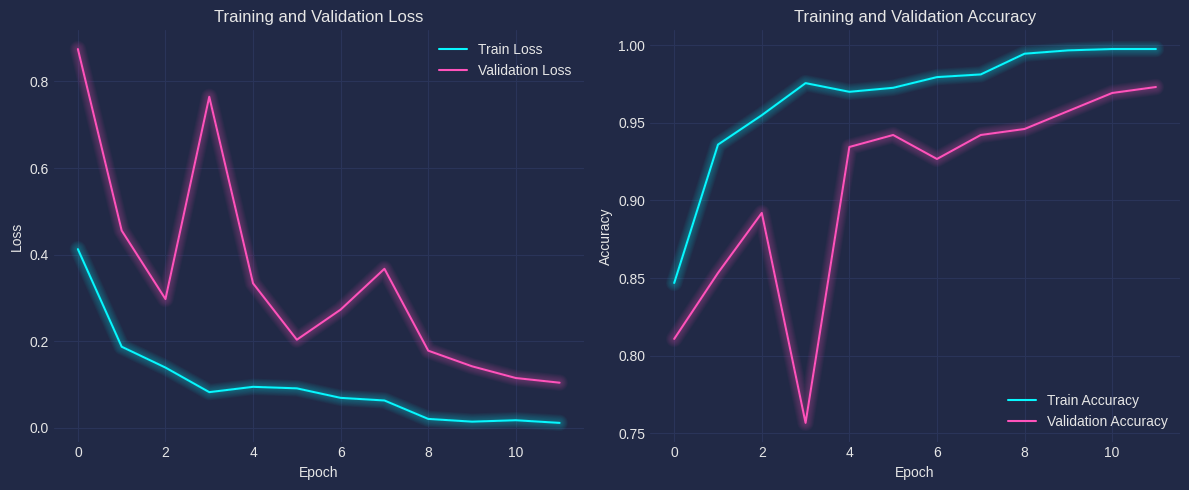

In [21]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Evaluation</p>

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


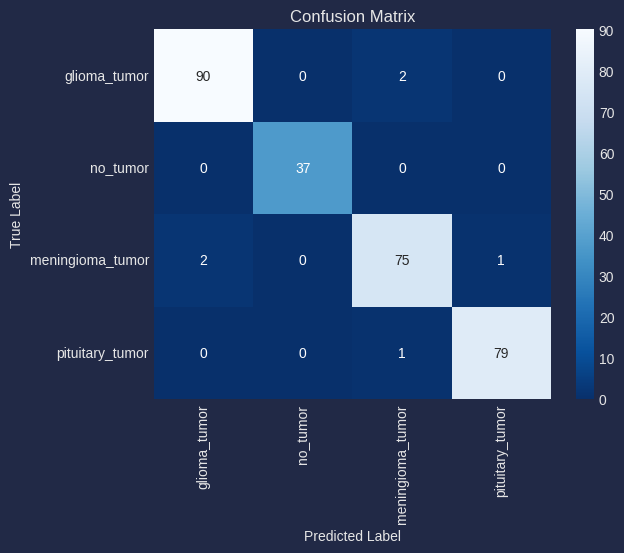

In [22]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        92
           1       1.00      1.00      1.00        37
           2       0.96      0.96      0.96        78
           3       0.99      0.99      0.99        80

    accuracy                           0.98       287
   macro avg       0.98      0.98      0.98       287
weighted avg       0.98      0.98      0.98       287



## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Prediction</p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



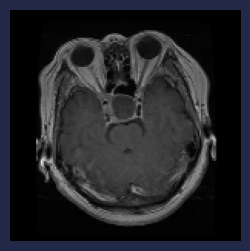

In [34]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

<a id="5"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">ResNet101</p>

ResNet-101, a 101-layer deep convolutional neural network, offers a pretrained version trained on over a million images from the ImageNet database. It excels in classifying images over 1000 object categories, demonstrating its adaptability in recognizing different objects and animals. ResNet-101, with an image input size of 224-by-224, uses extensive feature representations, making it a strong choice for a variety of image classification problems.

In [35]:
# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [36]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 42,666,372 (162.76 MB)

 Trainable params: 42,561,028 (162.36 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [37]:
!ls /content/dataset
!ls /content


ls: cannot access '/content/dataset': No such file or directory
brain-tumor-classification-mri.zip  kaggle_key.json  sample_data  Training
efficientnetB0.keras		    logs	     Testing


In [38]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [39]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.6262 - loss: 1.2151
Epoch 1: val_accuracy improved from -inf to 0.13900, saving model to efficientnetB0.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.6269 - loss: 1.2122 - val_accuracy: 0.1390 - val_loss: 2379.8594 - learning_rate: 0.0010
Epoch 2/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8348 - loss: 0.4692
Epoch 2: val_accuracy improved from 0.13900 to 0.42085, saving model to efficientnetB0.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 29s 396ms/step - accuracy: 0.8351 - loss: 0.4683 - val_accuracy: 0.4208 - val_loss: 1.7540 - learning_rate: 0.0010
Epoch 3/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9050 - loss: 0.2563
Epoch 3: val_accuracy improved from 0.42085 to 0.68340, saving model to efficientnetB0.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 37s 508ms/step - accuracy: 0.9051 - loss: 0.2560 - val_accuracy: 0.6834 - val_loss: 0.9157 - learning_rate: 0.0010
Epoch 4/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 0

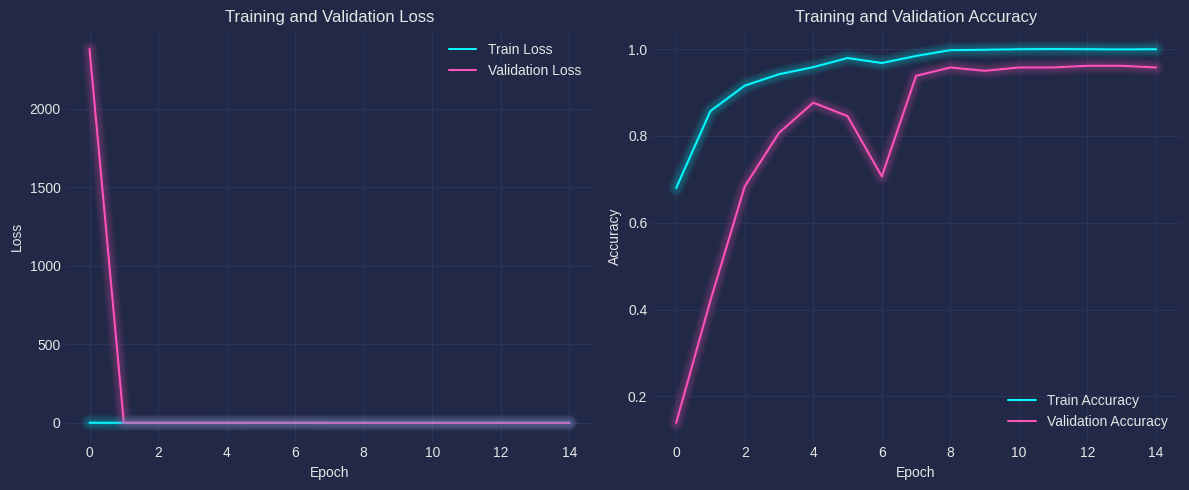

In [40]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Evaluation</p>

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


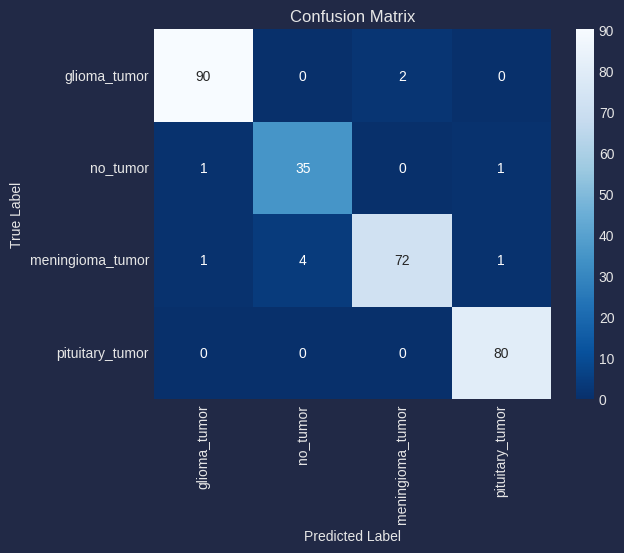

In [41]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        92
           1       0.90      0.95      0.92        37
           2       0.97      0.92      0.95        78
           3       0.98      1.00      0.99        80

    accuracy                           0.97       287
   macro avg       0.96      0.96      0.96       287
weighted avg       0.97      0.97      0.97       287



## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Prediction</p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted label: no_tumor 
Actual label: no_tumor 
Confidence: 99.87%



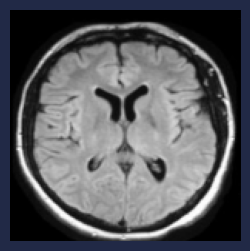

In [46]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

<a id="6"></a>
# <p style="background-color:#003166;font-family:newtimeroman;color:#ffffff;font-size:150%;text-align:center;border-radius:50px 10px;">Xception</p>

Xception, a revolutionary CNN architecture, incorporates depthwise separable convolutions, which reduces parameters and computational cost while maintaining efficacy. It uses separable convolutional blocks, an entry-exit flow structure, and skip connections similar to ResNet to provide efficient training and hierarchical feature learning. Key approaches include global depthwise convolutions for context understanding, data augmentation, batch normalization for stability, and transfer learning potential from ImageNet. With 71 layers, pretrained Xception performs at ImageNet classification, demonstrating its efficiency and adaptability in deep learning tasks.

In [47]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 36, 36,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 24,014,892 (91.61 MB)

 Trainable params: 23,960,364 (91.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [49]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [50]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.6180 - loss: 1.1553
Epoch 1: val_accuracy improved from -inf to 0.35907, saving model to efficientnetB0.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6197 - loss: 1.1504 - val_accuracy: 0.3591 - val_loss: 11.7998 - learning_rate: 0.0010
Epoch 2/12
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8870 - loss: 0.3330
Epoch 2: val_accuracy improved from 0.35907 to 0.65637, saving model to efficientnetB0.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 366ms/step - accuracy: 0.8873 - loss: 0.3323 - val_accuracy: 0.6564 - val_loss: 2.4401 - learning_rate: 0.0010
Epoch 3/12
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9429 - loss: 0.1678
Epoch 3: val_accuracy improved from 0.65637 to 0.80309, saving model to efficientnetB0.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 369ms/step - accuracy: 0.9429 - loss: 0.1680 - val_accuracy: 0.8031 - val_loss: 2.0340 - learning_rate: 0.0010
Epoch 4/12
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 

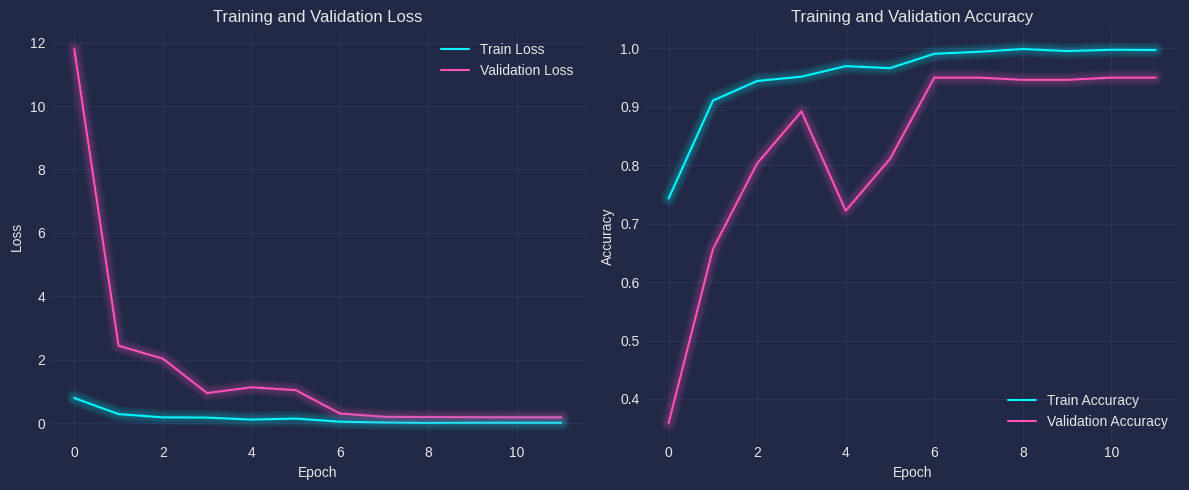

In [51]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Evaluation</p>

9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


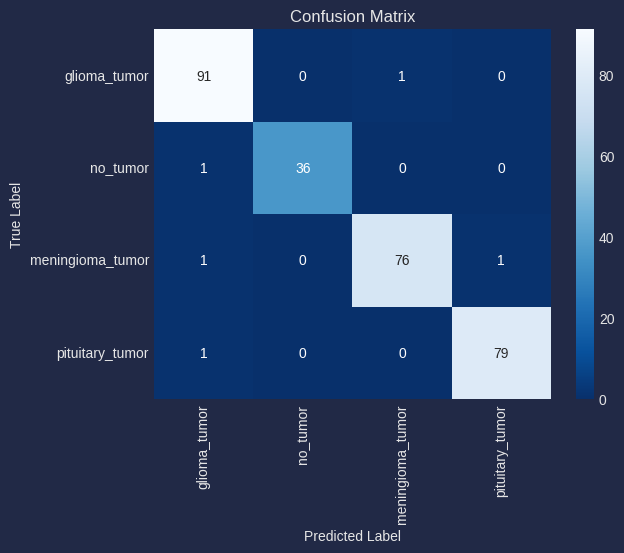

In [52]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [53]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        92
           1       1.00      0.97      0.99        37
           2       0.99      0.97      0.98        78
           3       0.99      0.99      0.99        80

    accuracy                           0.98       287
   macro avg       0.99      0.98      0.98       287
weighted avg       0.98      0.98      0.98       287



## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Prediction</p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 100.00%



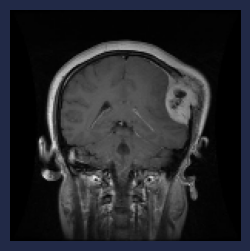

In [57]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


<a id="7"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;color:#ffffff;text-align:center;border-radius:50px 10px;">Conclusion</p>

Through the exploration of Transfer Learning models, including EfficientNet-b0, ResNet101, VGG 19, and Xception, this notebook has showcased the power of leveraging pre-existing knowledge to enhance classification accuracy. These models offer a robust framework for tackling the challenges posed by small datasets, exhibiting improved performance and paving the way for more accurate brain tumor detection.

# <p><center style="color:#003166;font-family:newtimeroman;;">Thank You!</center></p>